## Compare ChebyKAN's ability in function interpolation with MLP

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/KAN/ChebyKAN_old/')  # Add the directory to Python's path




Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time
from ChebyKANLayer import ChebyKANLayer

In [13]:
# Define target function (piecewise function)
def target_function(x):
    y = np.zeros_like(x)
    mask1 = x < 0.5
    y[mask1] = np.sin(20 * np.pi * x[mask1]) + x[mask1] ** 2
    mask2 = (0.5 <= x) & (x < 1.5)
    y[mask2] = 0.5 * x[mask2] * np.exp(-x[mask2]) + np.abs(np.sin(5 * np.pi * x[mask2]))
    mask3 = x >= 1.5
    y[mask3] = np.log(x[mask3] - 1) / np.log(2) - np.cos(2 * np.pi * x[mask3])

    # add noise
    noise = np.random.normal(0, 0, y.shape)
    y_noise = y + noise

    return y, y_noise

In [36]:
# Define target function highly oscillatory function (1/x) * cos(log(x)/x)
def target_function(x):
    y = np.zeros_like(x)
    mask1 = x <= 0
    y[mask1] = 0
    mask2 = x > 0
    y[mask2] = (1/x[mask2]) * np.cos(np.log(x[mask2])/x[mask2])


    # add noise
    noise = np.random.normal(0, 0.01, y.shape)
    y_noise = y + noise

    return y, y_noise

In [23]:
# Define target function (sqrt(x))
def target_function(x):
    y = np.zeros_like(x)
    mask1 = x < 0
    y[mask1] = 0
    mask2 = x >= 0
    y[mask2] = np.sqrt(x[mask2])


    # add noise
    noise = np.random.normal(0, 0.01, y.shape)
    y_noise = y + noise

    return y, y_noise

In [18]:
# Define target function (x**0.5 * (1-x)**(3/4))
def target_function(x):
    y = np.zeros_like(x)
    mask1 = x < 0
    y[mask1] = 0
    mask2 = (0 <= x) & (x <= 1)
    y[mask2] = x[mask2]**0.5 * (1-x[mask2])**(3/4)
    mask3 = x > 1
    y[mask3] = 0


    # add noise
    noise = np.random.normal(0, 0.01, y.shape)
    y_noise = y + noise

    return y, y_noise

In [6]:
# Define target function (exp(-x/0.01))
def target_function(x):
    y = np.zeros_like(x)
    mask1 = x >= 0
    y[mask1] = np.exp(-x[mask1]/0.01)




    # add noise
    noise = np.random.normal(0, 0.01, y.shape)
    y_noise = y + noise

    return y, y_noise

In [24]:
# Define MLP and ChebyKAN
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 128),
            nn.Tanh(),
            nn.Linear(128, 1),
        )

    def forward(self, x):
        return self.layers(x-1) # centralize the input


class ChebyKAN(nn.Module):
    def __init__(self):
        super(ChebyKAN, self).__init__()
        self.chebykan1 = ChebyKANLayer(1, 40, 40)
        self.chebykan2 = ChebyKANLayer(40, 1, 40)

    def forward(self, x):
        x = self.chebykan1(x)
        x = self.chebykan2(x)
        return x

In [25]:
import time

# Generate sample data
x_train = torch.linspace(0, 2, steps=500).unsqueeze(1)
y_target, y_train = target_function(x_train)
y_target, y_train = torch.tensor(y_target, dtype = torch.float32), torch.tensor(y_train, dtype = torch.float32)

# Instantiate models
cheby_model = ChebyKAN()
mlp_model = SimpleMLP()

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer_cheby = torch.optim.Adam(cheby_model.parameters(), lr=0.01)
optimizer_mlp = torch.optim.Adam(mlp_model.parameters(), lr=0.03)

cheby_losses = []

mlp_losses = []

# Start the timer
start_time = time.time()

# Train the models
epochs = 8000
l2_lambda = 0  # L2 regularization factor

for epoch in range(epochs):
    optimizer_cheby.zero_grad()
    outputs_cheby = cheby_model(x_train)
    loss_cheby = criterion(outputs_cheby, y_train)
    l2_norm_cheby = sum(p.pow(2.0).sum() for p in cheby_model.parameters())
    loss_cheby += l2_lambda * l2_norm_cheby
    loss_cheby_gen = criterion(outputs_cheby, y_target)
    loss_cheby.backward()
    optimizer_cheby.step()

    optimizer_mlp.zero_grad()
    outputs_mlp = mlp_model(x_train)
    loss_mlp = criterion(outputs_mlp, y_train)
    l2_norm_mlp = sum(p.pow(2.0).sum() for p in mlp_model.parameters())
    loss_mlp += l2_lambda * l2_norm_mlp
    loss_mlp_gen = criterion(outputs_mlp, y_target)
    loss_mlp.backward()
    optimizer_mlp.step()

    if epoch % 100 == 0:
        cheby_losses.append(loss_cheby.item())
        mlp_losses.append(loss_mlp.item())
        print(f'Epoch {epoch + 1}/{epochs}, ChebyKAN training Loss: {loss_cheby.item():.4e}, MLP training Loss: {loss_mlp.item():.4e}')
        print(f'Epoch {epoch + 1}/{epochs}, ChebyKAN Loss to original function: {loss_cheby_gen.item():.4e}, MLP Loss to original function: {loss_mlp_gen.item():.4e}')
        print()

# End the timer and calculate the total training time
end_time = time.time()
total_training_time = end_time - start_time
print(f'Total training time: {total_training_time:.2f} seconds')

# Test the models
#x_test = torch.linspace(0, 2, steps=400).unsqueeze(1)
x_test = x_train
y_pred_cheby = cheby_model(x_test).detach()
y_pred_mlp = mlp_model(x_test).detach()

Epoch 1/8000, ChebyKAN training Loss: 1.0126e+00, MLP training Loss: 2.4416e-01
Epoch 1/8000, ChebyKAN Loss to original function: 1.0127e+00, MLP Loss to original function: 2.4398e-01

Epoch 101/8000, ChebyKAN training Loss: 1.0536e-04, MLP training Loss: 1.3277e-03
Epoch 101/8000, ChebyKAN Loss to original function: 1.3549e-04, MLP Loss to original function: 1.2507e-03

Epoch 201/8000, ChebyKAN training Loss: 2.2295e-04, MLP training Loss: 1.0453e-03
Epoch 201/8000, ChebyKAN Loss to original function: 2.4660e-04, MLP Loss to original function: 9.6827e-04

Epoch 301/8000, ChebyKAN training Loss: 2.6582e-04, MLP training Loss: 6.1005e-04
Epoch 301/8000, ChebyKAN Loss to original function: 2.8940e-04, MLP Loss to original function: 5.2614e-04

Epoch 401/8000, ChebyKAN training Loss: 3.6451e-05, MLP training Loss: 4.5689e-04
Epoch 401/8000, ChebyKAN Loss to original function: 7.1500e-05, MLP Loss to original function: 3.6698e-04

Epoch 501/8000, ChebyKAN training Loss: 3.7795e-05, MLP tra

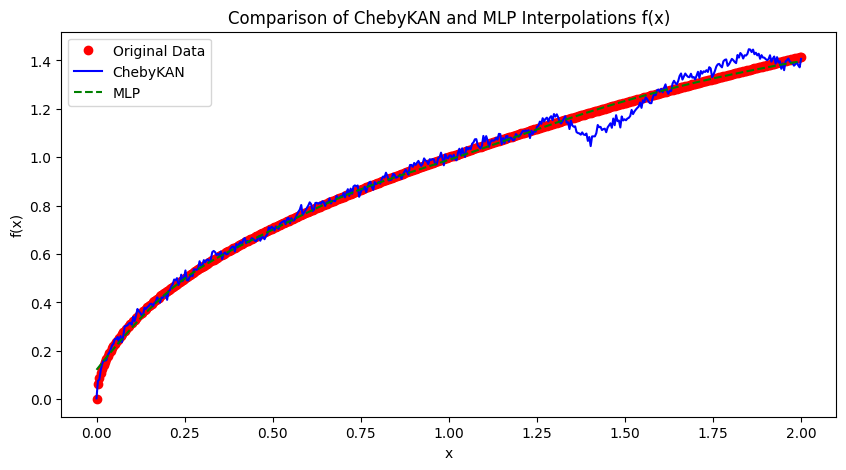

In [26]:
# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(x_train.numpy(), y_target.numpy(), 'ro', label='Original Data')
plt.plot(x_test.numpy(), y_pred_cheby.numpy(), 'b-', label='ChebyKAN')
plt.plot(x_test.numpy(), y_pred_mlp.numpy(), 'g--', label='MLP')
plt.title('Comparison of ChebyKAN and MLP Interpolations f(x)')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.show()

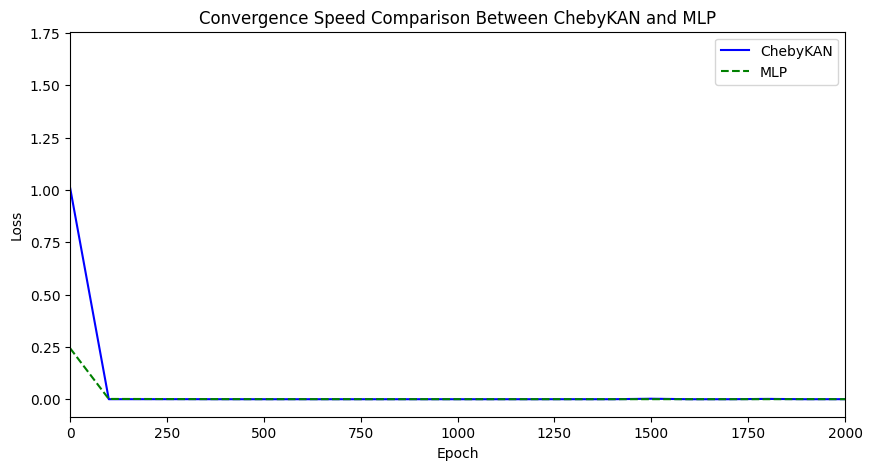

In [27]:
# Plot the convergence speed
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(range(0, epochs, 100), cheby_losses, 'b-', label='ChebyKAN')
plt.plot(range(0, epochs, 100), mlp_losses, 'g--', label='MLP')
plt.title('Convergence Speed Comparison Between ChebyKAN and MLP')
plt.xlim(0, 2000)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()